In [50]:
import pandas as pd
from google.cloud import bigquery
from google.oauth2 import service_account
import numpy as np
import json


In [51]:
class BigQuery():
    def __init__(self):
        self.credentials =json.load(open("credentials.json"))
        self.client = bigquery.Client(
            credentials=service_account.Credentials.from_service_account_info(self.credentials))

    def query(self, project, chave_nota = None):

        if project == "Intelipost":
            query = f"""
                    SELECT 
                   uf, transportadora, data_criacao, data_despacho,previsao_entrega_cliente,data_entrega,
                   previsao_entrega_transp,status_transportador,prazo_transportadora_dias_uteis,praca,
                   chave_da_nota,quantidade_de_ocorrencias
                    FROM `caffeine-web-server.Intelipost.pedido_entrega`
                    WHERE data_criacao > "2023-06-01"AND 
                    canal_de_vendas = "Ecommerce" AND
                    data_entrega IS NOT NULL AND
                    data_despacho IS NOT NULL
                    """
        elif project == 'ecommerce':
            query = f"""
                    WITH chaves AS(
                    SELECT numero_pedido_cliente, chave_acesso_NFe
                    FROM `caffeine-web-server.Omie_Caffeine_ES.Pedidos` 
                    WHERE chave_acesso_NFe IN {chave_nota}
                    )

                    SELECT chaves.chave_acesso_NFe, DATE(LEFT(shopify.criado_em,10)) as criado_shopify, 
                    FROM `caffeine-web-server.Shopify_BR.Pedidos` as shopify
                    INNER JOIN chaves ON shopify.id_pedido = chaves.numero_pedido_cliente
                    WHERE shopify.status_financeiro = "paid"
                    """

        result = self.bq_result(query)
        return result

    def bq_result(self, query_text):

        query_job = self.client.query(query_text)
        results = query_job.result()
        dataframe = pd.DataFrame([dict(row) for row in results])
        return dataframe
    


In [52]:
def get_date_order(chaves_de_nota):
    df_notas = pd.DataFrame()
    
    chunk_size = 15000
    num_chunks = len(chaves_de_nota) // chunk_size + (len(chaves_de_nota) % chunk_size > 0)

    # Loop to divide the tuple into chunks
    for i in range(num_chunks):
        start_index = i * chunk_size
        end_index = (i + 1) * chunk_size
        current_chunk = chaves_de_nota[start_index:end_index]

        df_temp = BigQuery().query("ecommerce",current_chunk)
        df_notas = pd.concat([df_temp,df_notas], axis=0, ignore_index = True)
    return df_notas


In [53]:
intelipost_data = BigQuery().query("Intelipost")

In [54]:
pd.set_option('display.max_columns', 500)
intelipost_data.head()

,uf,transportadora,data_criacao,data_despacho,previsao_entrega_cliente,data_entrega,previsao_entrega_transp,status_transportador,prazo_transportadora_dias_uteis,praca,chave_da_nota,quantidade_de_ocorrencias
0,MS,Total,2023-10-15 08:28:05.999000+00:00,2023-10-17 18:19:46+00:00,2023-11-01 23:58:59+00:00,2023-10-24 14:43:59+00:00,2023-10-30 23:59:59+00:00,Entregue,9.0,Capital,32231027403527000385550010003694421223920208,1.0
1,MT,Total,2023-10-16 18:04:51.632000+00:00,2023-10-17 18:19:46+00:00,2023-11-01 23:58:59+00:00,2023-10-27 11:54:59+00:00,2023-10-30 23:59:59+00:00,Entregue,9.0,Interior,32231027403527000385550010003704651604294733,1.0
2,SC,Loggi,2023-10-18 10:20:17.853000+00:00,2023-10-18 17:42:27+00:00,2023-11-01 23:58:59+00:00,2023-10-27 14:40:59+00:00,2023-10-26 23:59:59+00:00,Entregue,6.0,Interior,32231027403527000385550010003713691968754968,1.0
3,SP,Loggi,2023-10-18 08:07:42.429000+00:00,2023-10-18 17:42:27+00:00,2023-11-01 23:58:59+00:00,2023-10-25 18:23:59+00:00,2023-10-26 23:59:59+00:00,Entregue,6.0,Interior,32231027403527000385550010003711891757010537,1.0
4,SP,Loggi,2023-10-18 17:25:29.989000+00:00,2023-10-19 17:58:44+00:00,2023-10-24 23:58:59+00:00,2023-10-23 10:48:59+00:00,2023-10-24 23:59:59+00:00,Entregue,3.0,Capital,32231027403527000385550010003715971896074902,0.0


### Visualizing all columns and defining the importants

In [56]:
variaveis_interesse = intelipost_data

In [57]:
variaveis_interesse.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71290 entries, 0 to 71289
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype              
---  ------                           --------------  -----              
 0   uf                               71290 non-null  object             
 1   transportadora                   71290 non-null  object             
 2   data_criacao                     71290 non-null  datetime64[ns, UTC]
 3   data_despacho                    71290 non-null  datetime64[ns, UTC]
 4   previsao_entrega_cliente         71132 non-null  datetime64[ns, UTC]
 5   data_entrega                     71290 non-null  datetime64[ns, UTC]
 6   previsao_entrega_transp          71290 non-null  datetime64[ns, UTC]
 7   status_transportador             71290 non-null  object             
 8   prazo_transportadora_dias_uteis  71290 non-null  float64            
 9   praca                            71290 non-null  object             
 10

In [58]:
variaveis_interesse['previsao_entrega_cliente'] = variaveis_interesse['previsao_entrega_cliente'].fillna(variaveis_interesse['previsao_entrega_transp'])

In [350]:
variaveis_interesse['situacao'] = np.where((variaveis_interesse['previsao_entrega_cliente'] - variaveis_interesse['data_entrega'] ).dt.days.astype(int) < 0, "Atrasado","No prazo")

In [60]:
variaveis_interesse['situacao'].value_counts()

No prazo    60936
Atrasado    10354
Name: situacao, dtype: int64

### Filter only orders that have already been delivered

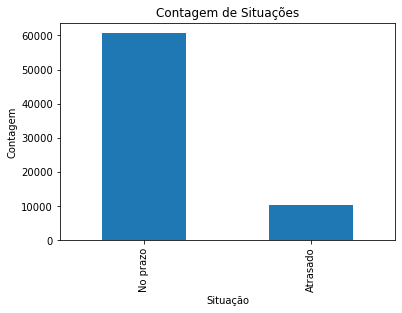

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Supondo que 'variaveis_interesse' é o seu DataFrame
# e 'situacao' é a coluna de interesse
variaveis_interesse['situacao'].value_counts().plot(kind='bar')

# Adicionando rótulos e título
plt.xlabel('Situação')
plt.ylabel('Contagem')
plt.title('Contagem de Situações')

# Exibindo o gráfico
plt.show()


C:\Users\rodri\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


<Figure size 720x432 with 0 Axes>

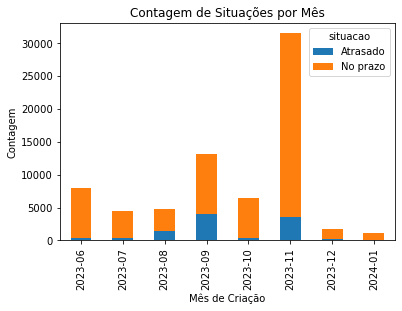

In [62]:
variaveis_interesse['mes'] = variaveis_interesse['data_criacao'].dt.to_period('M')

# Criando um gráfico de barras
plt.figure(figsize=(10, 6))
variaveis_interesse.groupby(['mes', 'situacao']).size().unstack().plot(kind='bar', stacked=True)

# Adicionando rótulos e título
plt.xlabel('Mês de Criação')
plt.ylabel('Contagem')
plt.title('Contagem de Situações por Mês')

# Exibindo o gráfico
plt.show()

In [315]:
df_volume = variaveis_interesse.groupby(['mes', 'situacao']).size().unstack()
df_volume['total'] = df_volume[0] + df_volume[1]
df_volume['prop'] = df_volume[1]/df_volume['total'] 
correlation = df_volume['prop'].corr(df_volume['total'])

print(f'Correlation between proportion late delivery and the volume total: {correlation}')


Correlation between column1 and column2: 0.1799081443213204


In [319]:
df_volume['prop']


mes
2023-06    0.054851
2023-07    0.082078
2023-08    0.305487
2023-09    0.301527
2023-10    0.051868
2023-11    0.114510
2023-12    0.080492
2024-01    0.012026
Freq: M, Name: prop, dtype: float64

In [64]:
contagem_por_mes_situacao = variaveis_interesse.groupby(['mes', 'situacao']).size().unstack()
contagem_por_mes_situacao['Porcentagem_Atrasado'] = (contagem_por_mes_situacao['Atrasado'] / contagem_por_mes_situacao.sum(axis=1)) * 100

In [65]:
contagem_por_mes_situacao

situacao,Atrasado,No prazo,Porcentagem_Atrasado
mes,,,
2023-06,437,7530,5.485126
2023-07,365,4082,8.207781
2023-08,1481,3367,30.548680
2023-09,3969,9194,30.152701
2023-10,336,6142,5.186786
2023-11,3609,27908,11.450963
2023-12,144,1645,8.049189
2024-01,13,1068,1.202590


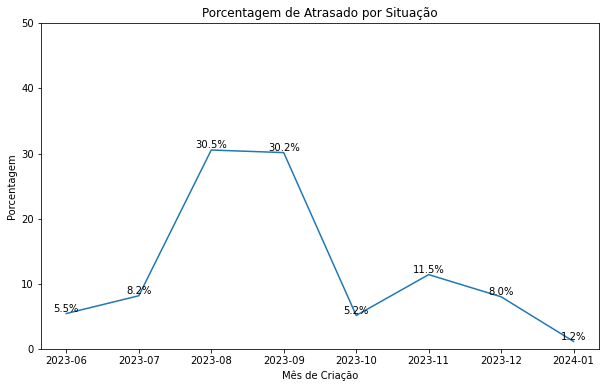

In [66]:
contagem_por_mes_situacao.index = contagem_por_mes_situacao.index.astype(str)

plt.figure(figsize=(10, 6))
ax = contagem_por_mes_situacao['Porcentagem_Atrasado'].plot(kind='line')
ax.set_ylim(0, 50)
plt.xlabel('Mês de Criação')
plt.ylabel('Porcentagem')
plt.title('Porcentagem de Atrasado por Situação')

for i, y in enumerate(contagem_por_mes_situacao['Porcentagem_Atrasado']):
    ax.text(i, y, f'{y:.1f}%', ha='center', va='bottom')
    
# Exibindo o gráfico
plt.show()

In [67]:
variaveis_interesse['situacao'].value_counts()

No prazo    60936
Atrasado    10354
Name: situacao, dtype: int64

In [68]:
porcentagem = round(10214 / (59354 + 10214),3)*100
print(f"Proporção de pedidos entregue atrasados {porcentagem} %")


Proporção de pedidos entregue atrasados 14.7 %


### Por transportadora

In [69]:
# Criando um gráfico de barras
transportadora_situacao = variaveis_interesse.groupby(['transportadora', 'situacao']).size().unstack()
transportadora_situacao['% entrega transp'] = round(transportadora_situacao['Atrasado'] / transportadora_situacao.sum(axis=1) * 100,2)
transportadora_situacao['% atraso totais'] =  round(transportadora_situacao['Atrasado'] / transportadora_situacao['Atrasado'].sum() *100,2)
transportadora_situacao


situacao,Atrasado,No prazo,% entrega transp,% atraso totais
transportadora,,,,
Braspress,50,32,60.98,0.48
Correios,47,230,16.97,0.45
Loggi,8749,42929,16.93,84.50
Total,1508,17745,7.83,14.56


## Análise por Estado

In [70]:
mapa = variaveis_interesse.groupby(['uf', 'situacao']).size().unstack()
mapa['% atraso totais'] =  round(mapa['Atrasado'] / mapa['Atrasado'].sum() *100,2)
mapa

situacao,Atrasado,No prazo,% atraso totais
uf,,,
AC,2.0,62.0,0.02
AL,23.0,344.0,0.22
AM,42.0,111.0,0.41
AP,2.0,15.0,0.02
BA,348.0,2969.0,3.36
CE,53.0,645.0,0.51
DF,342.0,2222.0,3.30
ES,183.0,1367.0,1.77
GO,145.0,1431.0,1.40


In [322]:
state_to_region = {
    'AC': 'Norte',
    'AL': 'Nordeste',
    'AP': 'Norte',
    'AM': 'Norte',
    'BA': 'Nordeste',
    'CE': 'Nordeste',
    'DF': 'CentroOeste',
    'ES': 'Sudeste',
    'GO': 'CentroOeste',
    'MA': 'Nordeste',
    'MT': 'CentroOeste',
    'MS': 'CentroOeste',
    'MG': 'Sudeste',
    'PA': 'Norte',
    'PB': 'Nordeste',
    'PR': 'Sul',
    'PE': 'Nordeste',
    'PI': 'Nordeste',
    'RJ': 'Sudeste',
    'RN': 'Nordeste',
    'RS': 'Sul',
    'RO': 'Norte',
    'RR': 'Norte',
    'SC': 'Sul',
    'SP': 'Sudeste',
    'SE': 'Nordeste',
    'TO': 'Norte',
}
variaveis_interesse['region'] = variaveis_interesse['uf'].map(state_to_region)

In [323]:
mapa = variaveis_interesse.groupby(['region', 'situacao']).size().unstack()
mapa['% atraso totais'] =  round(mapa['Atrasado'] / mapa['Atrasado'].sum() *100,2)
mapa

situacao,Atrasado,No prazo,% atraso totais
region,,,
CentroOeste,575,5104,5.55
Nordeste,749,5907,7.23
Norte,121,849,1.17
Sudeste,7260,39177,70.12
Sul,1649,9899,15.93


## Capital Interior

In [73]:
mapa = variaveis_interesse.groupby(['praca', 'situacao']).size().unstack()
mapa['% atraso totais'] =  round(mapa['Atrasado'] / mapa['Atrasado'].sum() *100,2)
mapa

situacao,Atrasado,No prazo,% atraso totais
praca,,,
Capital,7876,40390,76.07
Interior,2478,20546,23.93


### Transform a data retirando o UTC e hora

In [74]:
colunas_ajustar_data = ['data_entrega','data_criacao','previsao_entrega_transp',
                        'previsao_entrega_cliente','data_despacho']

for column in colunas_ajustar_data:
    base_modelo[column] = base_modelo[column].dt.date

NameError: name 'base_modelo' is not defined

In [ ]:
base_modelo['tempo_dias_despacho'] = (base_modelo['data_despacho'] - base_modelo['data_criacao']).dt.days.astype(int)

In [100]:
## Criar dummies transportadoras
dummy_df = pd.get_dummies(variaveis_interesse['transportadora'], prefix='transportadora')
variaveis_interesse = pd.concat([variaveis_interesse, dummy_df], axis=1)
variaveis_interesse.head()

,uf,transportadora,data_criacao,data_despacho,previsao_entrega_cliente,data_entrega,previsao_entrega_transp,status_transportador,prazo_transportadora_dias_uteis,praca,chave_da_nota,quantidade_de_ocorrencias,situacao,mes,region,regiao_Centro-Oeste,regiao_Nordeste,regiao_Norte,regiao_Sudeste,regiao_Sul,chave_acesso_NFe,criado_shopify,tempo_total_despacho,campaing,transportadora_Braspress,transportadora_Correios,transportadora_Loggi,transportadora_Total
0,MS,Total,2023-10-15 08:28:05.999000+00:00,2023-10-17 18:19:46+00:00,2023-11-01 23:58:59+00:00,2023-10-24 14:43:59+00:00,2023-10-30 23:59:59+00:00,Entregue,9.0,1,32231027403527000385550010003694421223920208,1.0,0,2023-10,Centro-Oeste,1,0,0,0,0,32231027403527000385550010003694421223920208,2023-10-15 00:00:00+00:00,2,0,0,0,0,1
1,MT,Total,2023-10-16 18:04:51.632000+00:00,2023-10-17 18:19:46+00:00,2023-11-01 23:58:59+00:00,2023-10-27 11:54:59+00:00,2023-10-30 23:59:59+00:00,Entregue,9.0,0,32231027403527000385550010003704651604294733,1.0,0,2023-10,Centro-Oeste,1,0,0,0,0,32231027403527000385550010003704651604294733,2023-10-16 00:00:00+00:00,1,0,0,0,0,1
2,SC,Loggi,2023-10-18 10:20:17.853000+00:00,2023-10-18 17:42:27+00:00,2023-11-01 23:58:59+00:00,2023-10-27 14:40:59+00:00,2023-10-26 23:59:59+00:00,Entregue,6.0,0,32231027403527000385550010003713691968754968,1.0,0,2023-10,Sul,0,0,0,0,1,32231027403527000385550010003713691968754968,2023-10-18 00:00:00+00:00,0,0,0,0,1,0
3,SP,Loggi,2023-10-18 08:07:42.429000+00:00,2023-10-18 17:42:27+00:00,2023-11-01 23:58:59+00:00,2023-10-25 18:23:59+00:00,2023-10-26 23:59:59+00:00,Entregue,6.0,0,32231027403527000385550010003711891757010537,1.0,0,2023-10,Sudeste,0,0,0,1,0,32231027403527000385550010003711891757010537,2023-10-18 00:00:00+00:00,0,0,0,0,1,0
4,SP,Loggi,2023-10-18 17:25:29.989000+00:00,2023-10-19 17:58:44+00:00,2023-10-24 23:58:59+00:00,2023-10-23 10:48:59+00:00,2023-10-24 23:59:59+00:00,Entregue,3.0,1,32231027403527000385550010003715971896074902,0.0,0,2023-10,Sudeste,0,0,0,1,0,32231027403527000385550010003715971896074902,2023-10-18 00:00:00+00:00,1,0,0,0,1,0


## Transform states in regions

In [213]:
dummy_df = pd.get_dummies(variaveis_interesse['region'], prefix='regiao',)
variaveis_interesse = pd.concat([variaveis_interesse, dummy_df], axis=1)
variaveis_interesse.head()

,uf,transportadora,data_criacao,data_despacho,previsao_entrega_cliente,data_entrega,previsao_entrega_transp,status_transportador,prazo_transportadora_dias_uteis,praca,chave_da_nota,quantidade_de_ocorrencias,situacao,mes,region,chave_acesso_NFe,criado_shopify,tempo_total_despacho,campaing,transportadora_Braspress,transportadora_Correios,transportadora_Loggi,transportadora_Total,regiao_CentroOeste,regiao_Nordeste,regiao_Norte,regiao_Sudeste,regiao_Sul
0,MS,Total,2023-10-15 08:28:05.999000+00:00,2023-10-17 18:19:46+00:00,2023-11-01 23:58:59+00:00,2023-10-24 14:43:59+00:00,2023-10-30 23:59:59+00:00,Entregue,9.0,1,32231027403527000385550010003694421223920208,1.0,0,2023-10,CentroOeste,32231027403527000385550010003694421223920208,2023-10-15 00:00:00+00:00,2,0,0,0,0,1,1,0,0,0,0
1,MT,Total,2023-10-16 18:04:51.632000+00:00,2023-10-17 18:19:46+00:00,2023-11-01 23:58:59+00:00,2023-10-27 11:54:59+00:00,2023-10-30 23:59:59+00:00,Entregue,9.0,0,32231027403527000385550010003704651604294733,1.0,0,2023-10,CentroOeste,32231027403527000385550010003704651604294733,2023-10-16 00:00:00+00:00,1,0,0,0,0,1,1,0,0,0,0
2,SC,Loggi,2023-10-18 10:20:17.853000+00:00,2023-10-18 17:42:27+00:00,2023-11-01 23:58:59+00:00,2023-10-27 14:40:59+00:00,2023-10-26 23:59:59+00:00,Entregue,6.0,0,32231027403527000385550010003713691968754968,1.0,0,2023-10,Sul,32231027403527000385550010003713691968754968,2023-10-18 00:00:00+00:00,0,0,0,0,1,0,0,0,0,0,1
3,SP,Loggi,2023-10-18 08:07:42.429000+00:00,2023-10-18 17:42:27+00:00,2023-11-01 23:58:59+00:00,2023-10-25 18:23:59+00:00,2023-10-26 23:59:59+00:00,Entregue,6.0,0,32231027403527000385550010003711891757010537,1.0,0,2023-10,Sudeste,32231027403527000385550010003711891757010537,2023-10-18 00:00:00+00:00,0,0,0,0,1,0,0,0,0,1,0
4,SP,Loggi,2023-10-18 17:25:29.989000+00:00,2023-10-19 17:58:44+00:00,2023-10-24 23:58:59+00:00,2023-10-23 10:48:59+00:00,2023-10-24 23:59:59+00:00,Entregue,3.0,1,32231027403527000385550010003715971896074902,0.0,0,2023-10,Sudeste,32231027403527000385550010003715971896074902,2023-10-18 00:00:00+00:00,1,0,0,0,1,0,0,0,0,1,0


## Tempo de faturamento

In [76]:
notas = tuple(variaveis_interesse['chave_da_nota'])

In [77]:
df_notas = get_date_order(notas)

In [78]:
df_notas.head()

,chave_acesso_NFe,criado_shopify
0,32230627403527000385550010002877661228020275,2023-06-01
1,32230627403527000385550010002877721439287171,2023-06-01
2,32230627403527000385550010002877751780132109,2023-06-01
3,32230627403527000385550010002877811892613947,2023-06-01
4,32230627403527000385550010002877991370164142,2023-06-01


In [79]:
df_notas.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70301 entries, 0 to 70300
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   chave_acesso_NFe  70301 non-null  object
 1   criado_shopify    70301 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [80]:
df_notas['criado_shopify'] = pd.to_datetime(df_notas['criado_shopify'])

In [81]:
variaveis_interesse = variaveis_interesse.merge(
    df_notas, 
    left_on = 'chave_da_nota', right_on = 'chave_acesso_NFe', 
    how = 'left'
)

In [82]:
variaveis_interesse.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71290 entries, 0 to 71289
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype              
---  ------                           --------------  -----              
 0   uf                               71290 non-null  object             
 1   transportadora                   71290 non-null  object             
 2   data_criacao                     71290 non-null  datetime64[ns, UTC]
 3   data_despacho                    71290 non-null  datetime64[ns, UTC]
 4   previsao_entrega_cliente         71290 non-null  datetime64[ns, UTC]
 5   data_entrega                     71290 non-null  datetime64[ns, UTC]
 6   previsao_entrega_transp          71290 non-null  datetime64[ns, UTC]
 7   status_transportador             71290 non-null  object             
 8   prazo_transportadora_dias_uteis  71290 non-null  float64            
 9   praca                            71290 non-null  object             
 10

In [83]:
variaveis_interesse['criado_shopify'].isnull().sum()

989

In [84]:
variaveis_interesse['criado_shopify'] = variaveis_interesse['criado_shopify'].fillna(variaveis_interesse['data_criacao'])

In [85]:
variaveis_interesse['criado_shopify']

0        2023-10-15 00:00:00
1        2023-10-16 00:00:00
2        2023-10-18 00:00:00
3        2023-10-18 00:00:00
4        2023-10-18 00:00:00
                ...         
71285    2023-06-17 00:00:00
71286    2023-06-17 00:00:00
71287    2023-06-17 00:00:00
71288    2023-06-17 00:00:00
71289    2023-06-17 00:00:00
Name: criado_shopify, Length: 71290, dtype: object

# Tempo integração até despacho

In [86]:
variaveis_interesse.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71290 entries, 0 to 71289
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype              
---  ------                           --------------  -----              
 0   uf                               71290 non-null  object             
 1   transportadora                   71290 non-null  object             
 2   data_criacao                     71290 non-null  datetime64[ns, UTC]
 3   data_despacho                    71290 non-null  datetime64[ns, UTC]
 4   previsao_entrega_cliente         71290 non-null  datetime64[ns, UTC]
 5   data_entrega                     71290 non-null  datetime64[ns, UTC]
 6   previsao_entrega_transp          71290 non-null  datetime64[ns, UTC]
 7   status_transportador             71290 non-null  object             
 8   prazo_transportadora_dias_uteis  71290 non-null  float64            
 9   praca                            71290 non-null  object             
 10

In [87]:
variaveis_interesse['criado_shopify'] = pd.to_datetime(variaveis_interesse['criado_shopify'],utc = True)

In [88]:
variaveis_interesse['tempo_total_despacho'] = (variaveis_interesse['data_despacho'] - variaveis_interesse['criado_shopify']).dt.days.astype(int)

<AxesSubplot:>

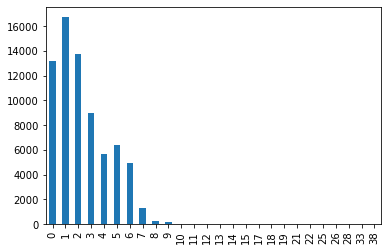

In [90]:
variaveis_interesse['tempo_total_despacho'].value_counts().sort_index().plot(kind='bar')


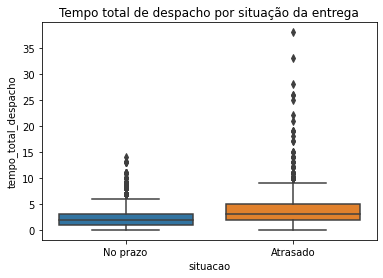

In [351]:
import matplotlib.pyplot as plt
import seaborn as sns


# Assuming 'tempo_total_despacho' is a numerical column in your DataFrame
# Replace 'your_dataframe' with the actual DataFrame containing your data

plt.title('Tempo total de despacho por situação da entrega')
sns.boxplot(x='situacao',y='tempo_total_despacho', data=variaveis_interesse)
plt.show()



In [377]:
tdespacho_estatis_atrasado = variaveis_interesse.query("situacao == 'No prazo'")['tempo_total_despacho'].describe()
tdespacho_estatis_noprazo = variaveis_interesse.query("situacao == 'Atrasado'")['tempo_total_despacho'].describe()
print(f'Estatística atrasado \n {tdespacho_estatis_atrasado}')
print()
print(f'Estatística no prazo \n {tdespacho_estatis_noprazo}')

Estatística atrasado 
 count    60936.000000
mean         2.190134
std          1.900008
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         14.000000
Name: tempo_total_despacho, dtype: float64

Estatística no prazo 
 count    10354.000000
mean         3.371934
std          2.342595
min          0.000000
25%          2.000000
50%          3.000000
75%          5.000000
max         38.000000
Name: tempo_total_despacho, dtype: float64


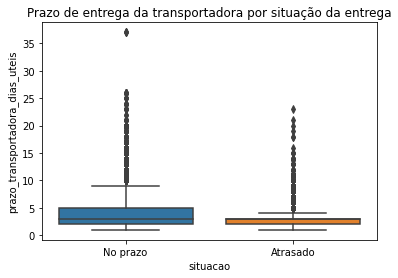

In [353]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.title('Prazo de entrega da transportadora por situação da entrega')
sns.boxplot(x='situacao',y='prazo_transportadora_dias_uteis', data=variaveis_interesse)
plt.show()



In [376]:
prazo_estatis_atrasado = variaveis_interesse.query("situacao == 'Atrasado'")['prazo_transportadora_dias_uteis'].describe()
prazo_estatis_noprazo = variaveis_interesse.query("situacao == 'No prazo'")['prazo_transportadora_dias_uteis'].describe()

print(f'Estatística atrasado \n {prazo_estatis_atrasado}')
print()
print(f'Estatística no prazo \n {prazo_estatis_noprazo}')

Estatística atrasado 
 count    10354.000000
mean         3.126328
std          1.797612
min          1.000000
25%          2.000000
50%          3.000000
75%          3.000000
max         23.000000
Name: prazo_transportadora_dias_uteis, dtype: float64

Estatística no prazo 
 count    60936.000000
mean         3.838552
std          2.328019
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
max         37.000000
Name: prazo_transportadora_dias_uteis, dtype: float64


## Campanha

In [94]:
# Define the date ranges and corresponding categories
'''

date_ranges = {
    'Choconilla': (pd.to_datetime('2023-04-10'), pd.to_datetime('2023-04-28')),
    'RTD': (pd.to_datetime('2023-07-11'), pd.to_datetime('2023-07-21')),
    'Paçoca': (pd.to_datetime('2023-08-28'), pd.to_datetime('2023-08-31')),
    'Beijinho': (pd.to_datetime('2023-09-25'), pd.to_datetime('2023-09-29')),
    'Black Friday':(pd.to_datetime('2023-11-05'),pd.to_datetime('2023-11-30'))}
'''

date_ranges = {
    'Choconilla': (pd.Timestamp('2023-04-10', tz='UTC'), pd.Timestamp('2023-04-28', tz='UTC')),
    'RTD': (pd.Timestamp('2023-07-11', tz='UTC'), pd.Timestamp('2023-07-21', tz='UTC')),
    'Paçoca': (pd.Timestamp('2023-08-28', tz='UTC'), pd.Timestamp('2023-08-31', tz='UTC')),
    'Beijinho': (pd.Timestamp('2023-09-25', tz='UTC'), pd.Timestamp('2023-09-29', tz='UTC')),
    'BlackFriday': (pd.Timestamp('2023-11-01', tz='UTC'), pd.Timestamp('2023-11-30', tz='UTC')),
    'Sampling': (pd.Timestamp('2023-10-23', tz='UTC'), pd.Timestamp('2023-11-01', tz='UTC')),
}


# Create a new column 'event' with values 1 or 0 based on date ranges
variaveis_interesse['campaing'] = 0  # Initialize 'event' column with 0
for category, (start_date, end_date) in date_ranges.items():
    variaveis_interesse.loc[variaveis_interesse['criado_shopify'].between(start_date, end_date), 'campaing'] = 1




In [95]:
# Display the resulting DataFrame
variaveis_interesse['campaing'].value_counts()

1    35821
0    35469
Name: campaing, dtype: int64

In [324]:
campanhas = variaveis_interesse.groupby(['campaing', 'situacao']).size().unstack()
campanhas

situacao,Atrasado,No prazo
campaing,,
0,6224,29245
1,4130,31691


In [96]:
variaveis_interesse.head()

,uf,transportadora,data_criacao,data_despacho,previsao_entrega_cliente,data_entrega,previsao_entrega_transp,status_transportador,prazo_transportadora_dias_uteis,praca,chave_da_nota,quantidade_de_ocorrencias,situacao,mes,region,regiao_Centro-Oeste,regiao_Nordeste,regiao_Norte,regiao_Sudeste,regiao_Sul,chave_acesso_NFe,criado_shopify,tempo_total_despacho,campaing
0,MS,Total,2023-10-15 08:28:05.999000+00:00,2023-10-17 18:19:46+00:00,2023-11-01 23:58:59+00:00,2023-10-24 14:43:59+00:00,2023-10-30 23:59:59+00:00,Entregue,9.0,Capital,32231027403527000385550010003694421223920208,1.0,No prazo,2023-10,Centro-Oeste,1,0,0,0,0,32231027403527000385550010003694421223920208,2023-10-15 00:00:00+00:00,2,0
1,MT,Total,2023-10-16 18:04:51.632000+00:00,2023-10-17 18:19:46+00:00,2023-11-01 23:58:59+00:00,2023-10-27 11:54:59+00:00,2023-10-30 23:59:59+00:00,Entregue,9.0,Interior,32231027403527000385550010003704651604294733,1.0,No prazo,2023-10,Centro-Oeste,1,0,0,0,0,32231027403527000385550010003704651604294733,2023-10-16 00:00:00+00:00,1,0
2,SC,Loggi,2023-10-18 10:20:17.853000+00:00,2023-10-18 17:42:27+00:00,2023-11-01 23:58:59+00:00,2023-10-27 14:40:59+00:00,2023-10-26 23:59:59+00:00,Entregue,6.0,Interior,32231027403527000385550010003713691968754968,1.0,No prazo,2023-10,Sul,0,0,0,0,1,32231027403527000385550010003713691968754968,2023-10-18 00:00:00+00:00,0,0
3,SP,Loggi,2023-10-18 08:07:42.429000+00:00,2023-10-18 17:42:27+00:00,2023-11-01 23:58:59+00:00,2023-10-25 18:23:59+00:00,2023-10-26 23:59:59+00:00,Entregue,6.0,Interior,32231027403527000385550010003711891757010537,1.0,No prazo,2023-10,Sudeste,0,0,0,1,0,32231027403527000385550010003711891757010537,2023-10-18 00:00:00+00:00,0,0
4,SP,Loggi,2023-10-18 17:25:29.989000+00:00,2023-10-19 17:58:44+00:00,2023-10-24 23:58:59+00:00,2023-10-23 10:48:59+00:00,2023-10-24 23:59:59+00:00,Entregue,3.0,Capital,32231027403527000385550010003715971896074902,0.0,No prazo,2023-10,Sudeste,0,0,0,1,0,32231027403527000385550010003715971896074902,2023-10-18 00:00:00+00:00,1,0


In [210]:
drop_columns = ['regiao_Centro-Oeste','regiao_Nordeste','regiao_Norte','regiao_Sudeste','regiao_Sul']
for i in drop_columns:
    variaveis_interesse = variaveis_interesse.drop(columns=i)

## Step Wise

In [275]:
y = variaveis_interesse['situacao']
X = variaveis_interesse[['quantidade_de_ocorrencias','prazo_transportadora_dias_uteis','praca','tempo_total_despacho',
                         'transportadora_Correios','transportadora_Total','transportadora_Loggi',
                         'campaing',
                        'regiao_CentroOeste','regiao_Nordeste','regiao_Norte','regiao_Sul']]

In [215]:
import statsmodels.api as sm
import pandas as pd

# Function for stepwise forward selection for logistic regression
def forward_selected_logistic(data, response):
    remaining = set(data.columns)
    remaining.remove(response)  # Remove the response variable
    selected = []
    current_score, best_new_score = 0, 0
    
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {}".format(response, ' + '.join(selected + [candidate]))
            model = sm.Logit.from_formula(formula, data)
            result = model.fit()
            score = result.prsquared  # Adjusted R-squared is not directly available for logistic regression
            scores_with_candidates.append((score, candidate))
        
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
            
            print(f"Added {best_candidate} with pseudo R-squared: {best_new_score}")
    
    formula = "{} ~ {}".format(response, ' + '.join(selected))
    model = sm.Logit.from_formula(formula, data)
    result = model.fit()
    return result

# Combine X and y into a single DataFrame
data = pd.concat([X, y], axis=1)

# Perform forward stepwise selection for logistic regression
result_logistic = forward_selected_logistic(data, 'situacao')

# Display the selected features and summary
print(result_logistic.model.formula)
print(result_logistic.summary())


Optimization terminated successfully.
         Current function value: 0.414350
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413887
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406674
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.414354
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411516
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414334
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406937
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413579
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413623
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410691
  

Added regiao_CentroOeste with pseudo R-squared: 0.1543233737788382
Optimization terminated successfully.
         Current function value: 0.350412
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.350379
         Iterations 7
Added regiao_Sul with pseudo R-squared: 0.1544063159659207
Optimization terminated successfully.
         Current function value: 0.350367
         Iterations 7
Added regiao_Nordeste with pseudo R-squared: 0.15443664966830672
Optimization terminated successfully.
         Current function value: 0.350367
         Iterations 7
situacao ~ tempo_total_despacho + campaing + prazo_transportadora_dias_uteis + transportadora_Total + praca + quantidade_de_ocorrencias + regiao_Norte + transportadora_Loggi + transportadora_Correios + regiao_CentroOeste + regiao_Sul + regiao_Nordeste
                           Logit Regression Results                           
Dep. Variable:               situacao   No. Observations:             

## Z Wald

In [378]:
import statsmodels.api as sm

# Fit logistic regression model
model = sm.Logit(y, X)
result = model.fit()

# Access Wald statistics and p-values
wald_statistic = result.wald_test(np.eye(len(result.params)))
print(wald_statistic)

Optimization terminated successfully.
         Current function value: 0.351045
         Iterations 7
<Wald test (chi2): statistic=[[23308.82228339]], p-value=0.0, df_denom=8>


C:\Users\rodri\anaconda3\lib\site-packages\statsmodels\base\model.py:1889: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


## Mudar as variáveis para binárias -> fora do prazo e praça

In [346]:
mapeamento = {
    "No prazo": 0, "Atrasado": 1,
    "Capital":1, "Interior":0,}


In [347]:
variaveis_interesse[['situacao','praca']] = variaveis_interesse[['situacao','praca']].replace(mapeamento)

### Definindo Variáveis X e Y

In [249]:
y = variaveis_interesse['situacao']
X = variaveis_interesse[['quantidade_de_ocorrencias','prazo_transportadora_dias_uteis','praca','tempo_total_despacho',
                         'transportadora_Correios','transportadora_Total','transportadora_Loggi',
                         'campaing',
                        'regiao_Norte','regiao_Centro-Oeste','regiao_Norte','regiao_Sudeste','regiao_Sul']]


### Separando em base e treino

In [338]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=31)

# Initialize the Logistic Regression model with balanced class weights
logistic_regression = LogisticRegression(class_weight='balanced')
logistic_regression.fit(X_train, y_train)

# Predict probabilities on the test set
y_proba = logistic_regression.predict_proba(X_test)[:, 1]




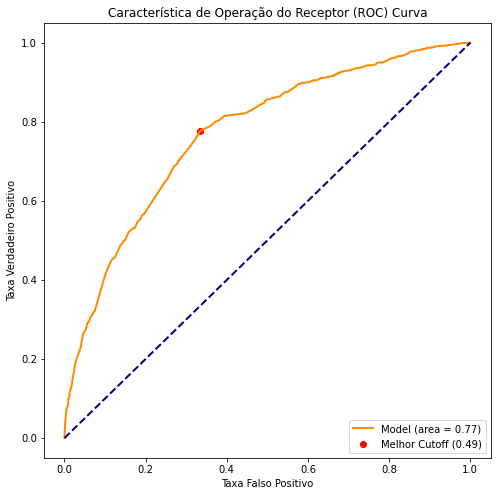

Best Cutoff: 0.48801


In [341]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming y_true is your true labels
y_true = y_test

# Model scores
y_scores_model = y_proba  # Replace this with the predicted scores for your model

# Compute ROC curve and ROC area
fpr_model, tpr_model, thresholds_model = roc_curve(y_true, y_scores_model)
roc_auc_model = auc(fpr_model, tpr_model)

# Calculate Youden's Index for each threshold
youden_index = tpr_model - fpr_model

# Find the threshold that maximizes Youden's Index
best_cutoff_index = np.argmax(youden_index)
best_cutoff = thresholds_model[best_cutoff_index]

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr_model, tpr_model, color='darkorange', lw=2, label='Model (area = {:.2f})'.format(roc_auc_model))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr_model[best_cutoff_index], tpr_model[best_cutoff_index], c='red', marker='o', label=f'Melhor Cutoff ({best_cutoff:.2f})')
plt.xlabel('Taxa Falso Positivo')
plt.ylabel('Taxa Verdadeiro Positivo')
plt.title('Característica de Operação do Receptor (ROC) Curva')
plt.legend(loc='lower right')
plt.show()

print(f'Best Cutoff: {best_cutoff:.5f}')


In [340]:
# Set a custom cutoff/threshold (e.g., 0.3)
custom_cutoff = best_cutoff
y_pred_custom = (y_proba >= custom_cutoff).astype(int)

acuracia = metrics.accuracy_score(y_test,y_pred_custom)
log_loss = metrics.log_loss(y_test,y_pred_custom)
roc_auc = metrics.roc_auc_score(y_test,y_pred_custom)
classification = metrics.classification_report(y_test, y_pred_custom)
cm = metrics.confusion_matrix(y_test, y_pred_custom)


print(f"variaveis independentes: {X.columns}\n")
print(f"Acurácia: {acuracia}\n")
print(f"Log loss: {log_loss}\n")
print(f"Curva Roc: {roc_auc}\n")
print(f"Classification Report")
print(classification)
print(f"matriz de confusão:")
print(cm)

variaveis independentes: Index(['prazo_transportadora_dias_uteis', 'praca', 'tempo_total_despacho',
       'transportadora_Correios', 'transportadora_Total',
       'transportadora_Loggi', 'campaing', 'regiao_Norte'],
      dtype='object')

Acurácia: 0.6818717387645178

Log loss: 10.987989368167849

Curva Roc: 0.7213116669993834

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.67      0.78     15237
           1       0.28      0.78      0.41      2586

    accuracy                           0.68     17823
   macro avg       0.61      0.72      0.60     17823
weighted avg       0.85      0.68      0.73     17823

matriz de confusão:
[[10144  5093]
 [  577  2009]]


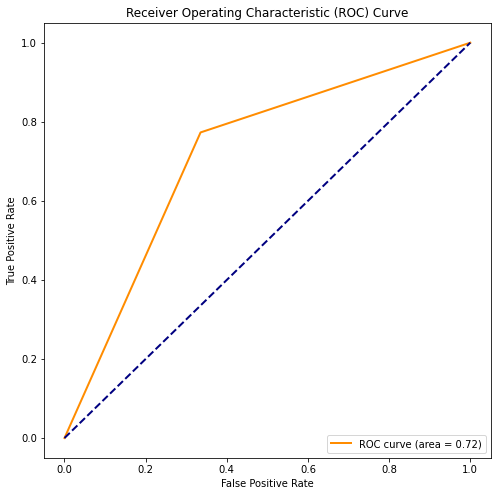

In [219]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming y_true is your true labels and y_scores is the predicted scores
# Replace them with your actual values
y_true = y_test
y_scores = y_pred_custom

# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


https://www.researchgate.net/figure/Sensitivity-vs-specificity-plot-for-decision-tree-and-logistic-regression-over-the_fig3_356763881

### Ploting  Confusion Matrix

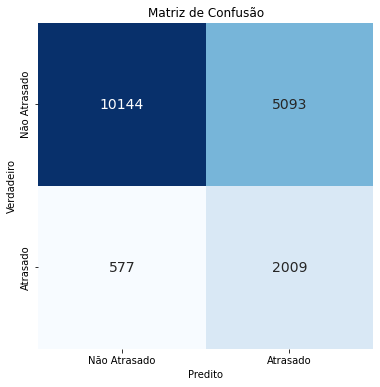

In [342]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            annot_kws={"size": 14}, xticklabels=["Não Atrasado", "Atrasado"],
            yticklabels=["Não Atrasado", "Atrasado"])
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

### Backlog

In [271]:
#Random Forest

from sklearn.ensemble import RandomForestClassifier

# Example with class_weight parameter
model = RandomForestClassifier(class_weight='balanced',random_state=31)
model.fit(X_train,y_train)
ypred = model.predict(X_test)

In [272]:
acuracia = metrics.accuracy_score(y_test,ypred)
log_loss = metrics.log_loss(y_test,ypred)
roc_auc = metrics.roc_auc_score(y_test,ypred)
classification = metrics.classification_report(y_test, ypred)
cm = metrics.confusion_matrix(y_test, ypred)


print(f"variaveis independentes: {X.columns}\n")
print(f"Acurácia: {acuracia}\n")
print(f"Log loss: {log_loss}\n")
print(f"Curva Roc: {roc_auc}\n")
print(f"Classification Report")
print(classification)
print(f"matriz de confusão:")
print(cm)


variaveis independentes: Index(['prazo_transportadora_dias_uteis', 'praca', 'tempo_total_despacho',
       'transportadora_Correios', 'transportadora_Total',
       'transportadora_Loggi', 'campaing', 'regiao_Norte'],
      dtype='object')

Acurácia: 0.7231028194697714

Log loss: 9.563880308569066

Curva Roc: 0.7307567193971997

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.72      0.82     12125
           1       0.32      0.74      0.44      2133

    accuracy                           0.72     14258
   macro avg       0.63      0.73      0.63     14258
weighted avg       0.85      0.72      0.76     14258

matriz de confusão:
[[8728 3397]
 [ 551 1582]]


In [265]:
import pandas as pd
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, log_loss, roc_auc_score

# Assuming you have a DataFrame 'data' with features and target variable
# For demonstration purposes, replace 'X' and 'y' with your actual feature matrix and target variable
X = data.drop('situacao', axis=1)
y = data['situacao']

# Define the classifier (replace with your actual model)
classifier = LogisticRegression(class_weight='balanced')

# Define the evaluation metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'log_loss': make_scorer(log_loss, greater_is_better=False, needs_proba=True),
    'roc_auc': make_scorer(roc_auc_score)
}

# Perform cross-validation with 5 folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate the model using cross_validate
results = cross_validate(classifier, X, y, cv=cv, scoring=scoring, return_train_score=False, verbose=2)
print(results)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
{'fit_time': array([0.6467638 , 0.73107934, 0.73661184, 0.73177886, 0.76480103]), 'score_time': array([0.02371526, 0.02359915, 0.03596139, 0.02414465, 0.02203488]), 'test_accuracy': array([0.6968018 , 0.69918642, 0.69147145, 0.69967737, 0.69904615]), 'test_log_loss': array([-0.57006838, -0.57050112, -0.57513248, -0.56996629, -0.56971448]), 'test_roc_auc': array([0.72700447, 0.71461435, 0.71310737, 0.71870918, 0.71994315])}


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.7s finished


In [266]:
results

{'fit_time': array([0.6467638 , 0.73107934, 0.73661184, 0.73177886, 0.76480103]),
 'score_time': array([0.02371526, 0.02359915, 0.03596139, 0.02414465, 0.02203488]),
 'test_accuracy': array([0.6968018 , 0.69918642, 0.69147145, 0.69967737, 0.69904615]),
 'test_log_loss': array([-0.57006838, -0.57050112, -0.57513248, -0.56996629, -0.56971448]),
 'test_roc_auc': array([0.72700447, 0.71461435, 0.71310737, 0.71870918, 0.71994315])}

In [273]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score

# Assuming you have a DataFrame 'data' with features and target variable
# For demonstration purposes, replace 'X' and 'y' with your actual feature matrix and target variable
X = data.drop('situacao', axis=1)
y = data['situacao']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate class weights based on the inverse of class frequencies
class_weights = len(y_train) / (2 * np.bincount(y_train))

# Initialize the Gradient Boosting model
gradient_boosted_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Fit the model on the training data with sample weights
gradient_boosted_model.fit(X_train, y_train, sample_weight=np.vectorize(class_weights.__getitem__)(y_train))

# Make predictions on the test set
y_pred = gradient_boosted_model.predict(X_test)
y_proba = gradient_boosted_model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
logloss = log_loss(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"Log Loss: {logloss:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")


Accuracy: 0.6966
Log Loss: 0.5386
ROC AUC: 0.7999


# ANOTAÇÕES

### COMPARE 2 ROC MODELS

In [226]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming y_true is your true labels
y_true = y_test

# Model 1 scores
y_scores_model1 = y_proba # Replace this with the predicted scores for Model 1

# Model 2 scores
y_scores_model2 = y_proba2 # Replace this with the predicted scores for Model 2

# Compute ROC curve and ROC area for each model
fpr_model1, tpr_model1, thresholds_model1 = roc_curve(y_true, y_scores_model1)
roc_auc_model1 = auc(fpr_model1, tpr_model1)

fpr_model2, tpr_model2, thresholds_model2 = roc_curve(y_true, y_scores_model2)
roc_auc_model2 = auc(fpr_model2, tpr_model2)

fpr_model1, tpr_model1, thresholds_model1 = roc_curve(y_true, y_scores_model1)

# Calculate Youden's Index for each threshold
youden_index = tpr_model1 - fpr_model1

# Find the threshold that maximizes Youden's Index
best_cutoff_index = np.argmax(youden_index)
best_cutoff = thresholds[best_cutoff_index]

# Plot ROC curves for both models
plt.figure(figsize=(8, 8))
plt.plot(fpr_model1, tpr_model1, color='darkorange', lw=2, label='Model 1 (area = {:.2f})'.format(roc_auc_model1))
plt.plot(fpr_model2, tpr_model2, color='green', lw=2, label='Model 2 (area = {:.2f})'.format(roc_auc_model2))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[best_cutoff_index], tpr[best_cutoff_index], c='red', marker='o', label=f'Best Cutoff ({best_cutoff:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print(f'Best Cutoff: {best_cutoff:.5f}')


IndexError: index 325 is out of bounds for axis 0 with size 3